# Section 4. Latent Semantic Analysis

## Latent Semantic Analysis Overview

- multiple words with the same meaning (synonyms): 'buy' and 'puchase'
- one word with multiple meanings (polysemy): 'Milk' or 'milk it'


**Latent Variables:**
- A variables that represents all synonyms
- challenge is to transorm original data and transform them into the common latent variables
    - z = 0.7 * computer + 0.5 * PC + 0.6 * Laptop
- However this doesnt always work for polysemy, works better for synonyms


    

# Mechanics of LSA
 - **LSA IS REALLY just the application of SVD (singular value decomposition) on the term document matrix.**
 - But before we learn about SVD we need to learn more about PCA, a simpler version of SVD
 
 ## PCA (Principal Components Analysis)
 
- z = Qx
- Q is a , I guess is x is the eigenvector matrix?
- scalar * vector = another vector, same direction
- matrix * vector = another vector, possible DIFFERENT direction
- PCA rotates our original input vectors... So you could think of it as the same vectors but in a different coordinate system

PCA does 3 things for us:
- Decorrelates the input date
- Transformed data is ordered by information content (variance)
- Dimensionality reduction
    - Note that removing information != decreasing predictive abilitiy
    - If our original vocab is 1000 words, if we join all words by how often they co-occur in each document, the total number of destinct LATENT terms is only 100. 
    - This is also a good way to de-noise or smooth data
    
### Covariance matrix

In the covariance matrix:
- the diagonals: tell us the variance of that direction
- the off diagonals: tell us how correlated 2 different dimensions are with each other

###### Remember: more variance is synonymous with MORE information.

The covariance matrix is computed by the following equation:

$S = 1/N (X - \pmb m)\;(X - \pmb m)^T$

where **m** is the mean vector: $\pmb m = \frac{1}{n} \sum\limits_{k=1}^n \; \pmb x_k$

### Eigenvalues and Eigenvecors
- A = diagonal matrix of eigenvalues (there are D of them, D is num dimensions in the orignal dataset)
- Q = matrix of stacked eigenvectors (there are D of them,  D is num dimensions in the orignal dataset)
- we sort A so that eigenvalues are in descending order
- remember that z = Qz
- it turns out that A is the covariance matrix of z, therefore:
    - variance aka information in Z is sorted in descending order
    - none of the dimensions in Z are correlated.
    
Learn more : https://lazyprogrammer.me/tutorial-principal-components-analysis-pca/


## Extending PCA

PCA helps us combine input features in the term document matrix. But what if we wanted to combine and decorrelate by document? ** Just do PCA on the transpose?** 

**Strange Result:**
- still have D eigenvalues (covariance is N * N)
- they are the same eigenvalues we found before

## SVD (singular value decomposition)

SVD just does PCA on both of these at the same time! As mentioned above, the eigevnalues of the covariance matrices will be the same, but the eigenvectors will be different!

1. Find eigenvalues (S^2) and eignevectors (U) of XX_T
2. Find eigenvalues (S^2) and eignevectors (V) of X_TX

There are related by:

X=U\*S\*V_T

- ie X is decomposed into 3 parts (U, S, V_T)
- we can transform both terms AND documents
- get the "low-rank" approximation of X by keeping first k elements of U,S,V


    

# Lets write some code!

In [4]:
# Author: http://lazyprogrammer.me
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer

## Import functions and stopwords

In [5]:
#import lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
()
#import data line by line
#remove training whitespace with rstrip
titles = [line.rstrip() for line in open('data/all_book_titles.txt')]

#import stopwords
from nltk.corpus import stopwords
all_stopwords = set(stopwords.words('english'))
len(all_stopwords)

179

In [6]:
#add more stopwords
all_stopwords = all_stopwords.union({
    'introduction', 'edition', 'series', 'application',
    'approach', 'card', 'access', 'package', 'plus', 'etext',
    'brief', 'vol', 'fundamental', 'guide', 'essential', 'printed',
    'third', 'second', 'fourth', })
len(all_stopwords)

198

## Create sentence tokenizer

In [7]:
#create tokenizer
def mc_tokenizer(s):
    s = s.lower() #downcase
    tokens = nltk.tokenize.word_tokenize(s)
    tokens = [t for t in tokens if len(t) > 2] #remove short words
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens]
    tokens = [t for t in tokens if t not in all_stopwords] #remove stopwords
    tokens = [t for t in tokens if not any(c.isdigit() for c in t)]
    return tokens
    
print('hello')

hello


## First create wordindex and vector in Sklearn

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer=mc_tokenizer)
titles_countvec = vectorizer.fit_transform(titles)

#transpose to put words along rows, and documents along columns
titles_countvec = titles_countvec.T
print('tokens length (instances) = ', len(titles))
print('word map (vocab) length = ', len(vectorizer.vocabulary_))
print('vector size = ', titles_countvec.A.shape)

tokens length (instances) =  2373
word map (vocab) length =  2132
vector size =  (2132, 2373)


## Manually Create WordIndex and Vector

In [9]:
# create a word-to-index map so that we can create our word-frequency vectors later
# let's also save the tokenized versions so we don't have to tokenize again later
word_index_map = {}
current_index = 0
all_tokens = []
all_titles = []
index_word_map = []
error_count = 0
for title in titles:
    try:
        title = title.encode('ascii', 'ignore').decode('utf-8') # this will throw exception if bad characters
        all_titles.append(title)
        tokens = mc_tokenizer(title)
        all_tokens.append(tokens)
        for token in tokens:
            if token not in word_index_map:
                word_index_map[token] = current_index
                current_index += 1
                index_word_map.append(token)
    except Exception as e:
        print(e)
        print(title)
        error_count += 1

print("Number of errors parsing file:", error_count, "number of lines in file:", len(titles))
if error_count == len(titles):
    print("There is no data to do anything with! Quitting...")
    exit()


# now let's create our input matrices
# just indicator variables for this example - works better than proportions
def tokens_to_vector(tokens):
    x = np.zeros(len(word_index_map))
    for t in tokens:
        i = word_index_map[t]
        x[i] = 1
    return x

N = len(all_tokens)
D = len(word_index_map)
X = np.zeros((D, N)) # terms will go along rows, documents along columns
i = 0
for tokens in all_tokens:
    X[:,i] = tokens_to_vector(tokens)
    i += 1
    
print('tokens length (instances) = ', N)
print('word map (vocab) length = ', D)
print('vector size = ', X.shape )

Number of errors parsing file: 0 number of lines in file: 2373
tokens length (instances) =  2373
word map (vocab) length =  2130
vector size =  (2130, 2373)


## Now run SVD

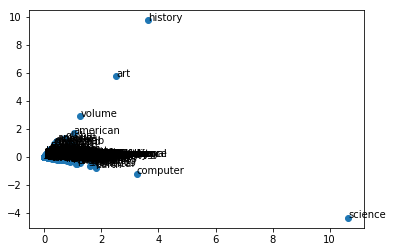

<Figure size 1440x1440 with 0 Axes>

In [10]:
from sklearn.decomposition import TruncatedSVD
def SVDfunc(X,figsize=(20,20)):
    svd = TruncatedSVD()
    Z = svd.fit_transform(X)
    plt.scatter(Z[:,0], Z[:,1])
    for i in range(D):
        plt.annotate(s=index_word_map[i], xy=(Z[i,0], Z[i,1]))
    plt.figure(figsize=(figsize))
    plt.show()

SVDfunc(X)